In [1]:
import os

import dgl
import pandas as pd
import torch
from dgl.data import DGLDataset, extract_archive
from dgl.data.utils import save_graphs, load_graphs
import json

import matplotlib.pyplot as plt
import networkx as nx

/home/truonghm/learning/m2-internship/gnn-recsys/.conda/gnn-recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def iter_json(filename):
    with open(filename, encoding='utf8') as f:
        for line in f:
            yield json.loads(line)

In [3]:
class OAGCSDataset(DGLDataset):
    """Micrsoft OAG 2.1 dataset, filtered to Computer Science topic, containing only one heterogeneous graph

    Statistics
    -----
    Vertices

    * 2248205 author
    * 1852225 paper
    * 11177 venue
    * 13747 institution
    * 120992 field

    Edges

    * 6349317 author-writes->paper
    * 1852225 paper-published_at->venue
    * 17250107 paper-has_field->field
    * 9194781 paper-cites->paper
    * 1726212 author-affiliated_with->institution

    Paper vertex attributes
    -----
    * feat: tensor(N_paper, 128) Pre-trained title and abstract word vectors
    * year: tensor(N_paper) Publication year (2010~2021)
    * citation: tensor(N_paper) Number of citations
    * Does not include labels

    Field vertex attributes
    -----
    * feat: tensor(N_field, 128) Pre-trained field vectors

    Writes edge attributes
    -----
    * order: tensor(N_writes) Author order (starting from 1)
    """

    def __init__(self, **kwargs):
        super().__init__('oag-cs', 'na', **kwargs)

    def download(self):
        zip_file_path = os.path.join(self.raw_dir, 'oag-cs.zip')
        if not os.path.exists(zip_file_path):
            for root, dirs, files in os.walk(self.raw_dir):
                for d in dirs:
                    if d.startswith('oag-cs_'):
                        os.rename(os.path.join(root, d), self.raw_path)
                        return
            else:
                raise FileNotFoundError(f'A zip file called `oag-cs.zip` is required in {self.raw_dir}')
        extract_archive(zip_file_path, self.raw_path)

    def save(self):
        save_graphs(os.path.join(self.save_path, self.name + '_dgl_graph.bin'), [self.g])

    def load(self):
        self.g = load_graphs(os.path.join(self.save_path, self.name + '_dgl_graph.bin'))[0][0]

    def process(self):
        self._vid_map = self._read_venues()  # {original id: vertex id}
        self._oid_map = self._read_institutions()  # {original id: vertex id}
        self._fid_map = self._read_fields()  # {field name: vertex id}
        self._aid_map, author_inst = self._read_authors()  # {original id: vertex id}, R(aid, oid)
        # PA(pid, aid), PV(pid, vid), PF(pid, fid), PP(pid, rid), [year], [citation count]
        paper_author, paper_venue, paper_field, paper_ref, paper_year, paper_citation = self._read_papers()
        self.g = self._build_graph(paper_author, paper_venue, paper_field, paper_ref, author_inst, paper_year, paper_citation)

    def _iter_json(self, filename):
        yield from iter_json(os.path.join(self.raw_path, filename))

    def _read_venues(self):
        print('Reading journal data...')
        # Line number = Index = Vertex id
        return {v['id']: i for i, v in enumerate(self._iter_json('mag_venues.txt'))}

    def _read_institutions(self):
        print('Reading institution data...')
        return {o['id']: i for i, o in enumerate(self._iter_json('mag_institutions.txt'))}

    def _read_fields(self):
        print('Reading field data...')
        return {f['name']: f['id'] for f in self._iter_json('mag_fields.txt')}

    def _read_authors(self):
        print('Reading scholar data...')
        author_id_map, author_inst = {}, []
        for i, a in enumerate(self._iter_json('mag_authors.txt')):
            author_id_map[a['id']] = i
            if a['org'] is not None:
                author_inst.append([i, self._oid_map[a['org']]])
        return author_id_map, pd.DataFrame(author_inst, columns=['aid', 'oid'])

    def _read_papers(self):
        print('Reading paper data...')
        paper_id_map, paper_author, paper_venue, paper_field = {}, [], [], []
        paper_year, paper_citation = [], []
        for i, p in enumerate(self._iter_json('mag_papers.txt')):
            paper_id_map[p['id']] = i
            paper_author.extend([i, self._aid_map[a], r + 1] for r, a in enumerate(p['authors']))
            paper_venue.append([i, self._vid_map[p['venue']]])
            paper_field.extend([i, self._fid_map[f]] for f in p['fos'] if f in self._fid_map)
            paper_year.append(p['year'])
            paper_citation.append(p['n_citation'])

        paper_ref = []
        for i, p in enumerate(self._iter_json('mag_papers.txt')):
            paper_ref.extend([i, paper_id_map[r]] for r in p['references'] if r in paper_id_map)
        return (
            pd.DataFrame(paper_author, columns=['pid', 'aid', 'order']).drop_duplicates(subset=['pid', 'aid']),
            pd.DataFrame(paper_venue, columns=['pid', 'vid']),
            pd.DataFrame(paper_field, columns=['pid', 'fid']),
            pd.DataFrame(paper_ref, columns=['pid', 'rid']),
            paper_year, paper_citation
        )

    def _build_graph(self, paper_author, paper_venue, paper_field, paper_ref, author_inst, paper_year, paper_citation):
        print('Constructing the heterogeneous graph...')
        pa_p, pa_a = paper_author['pid'].to_list(), paper_author['aid'].to_list()
        pv_p, pv_v = paper_venue['pid'].to_list(), paper_venue['vid'].to_list()
        pf_p, pf_f = paper_field['pid'].to_list(), paper_field['fid'].to_list()
        pp_p, pp_r = paper_ref['pid'].to_list(), paper_ref['rid'].to_list()
        ai_a, ai_i = author_inst['aid'].to_list(), author_inst['oid'].to_list()
        g = dgl.heterograph({
            ('author', 'writes', 'paper'): (pa_a, pa_p),
            ('paper', 'published_at', 'venue'): (pv_p, pv_v),
            ('paper', 'has_field', 'field'): (pf_p, pf_f),
            ('paper', 'cites', 'paper'): (pp_p, pp_r),
            ('author', 'affiliated_with', 'institution'): (ai_a, ai_i)
        })
        g.nodes['paper'].data['feat'] = torch.load(os.path.join(self.raw_path, 'paper_feat.pkl'))
        g.nodes['paper'].data['year'] = torch.tensor(paper_year)
        g.nodes['paper'].data['citation'] = torch.tensor(paper_citation)
        g.nodes['field'].data['feat'] = torch.load(os.path.join(self.raw_path, 'field_feat.pkl'))
        g.edges['writes'].data['order'] = torch.tensor(paper_author['order'].to_list())
        return g

    def has_cache(self):
        return os.path.exists(os.path.join(self.save_path, self.name + '_dgl_graph.bin'))

    def __getitem__(self, idx):
        if idx != 0:
            raise IndexError('This dataset has only one graph')
        return self.g

    def __len__(self):
        return 1

In [4]:
data = OAGCSDataset(raw_dir="../data")

In [5]:
data.g

Graph(num_nodes={'author': 2248205, 'field': 120992, 'institution': 13747, 'paper': 1852225, 'venue': 11177},
      num_edges={('author', 'affiliated_with', 'institution'): 1726212, ('author', 'writes', 'paper'): 6349317, ('paper', 'cites', 'paper'): 9194781, ('paper', 'has_field', 'field'): 17250107, ('paper', 'published_at', 'venue'): 1852225},
      metagraph=[('author', 'institution', 'affiliated_with'), ('author', 'paper', 'writes'), ('paper', 'paper', 'cites'), ('paper', 'field', 'has_field'), ('paper', 'venue', 'published_at')])

In [6]:
data.g.canonical_etypes

[('author', 'affiliated_with', 'institution'),
 ('author', 'writes', 'paper'),
 ('paper', 'cites', 'paper'),
 ('paper', 'has_field', 'field'),
 ('paper', 'published_at', 'venue')]

In [7]:
import random

def convert_to_networkx(g, edge_type):
    src, dst = g.edges(etype=edge_type)
    nx_g = nx.DiGraph()
    nx_g.add_edges_from(zip(src.numpy(), dst.numpy()))
    return nx_g

def select_subset_nodes(g, node_type, subset_size=100):
    nodes = g.nodes(node_type)
    random_nodes = random.sample(nodes.numpy().tolist(), subset_size)
    return random_nodes

def create_subgraph(g, nodes):
    return g.subgraph(nodes)

nx_g = convert_to_networkx(data.g, edge_type=('paper', 'cites', 'paper'))

In [14]:
random.seed(123)

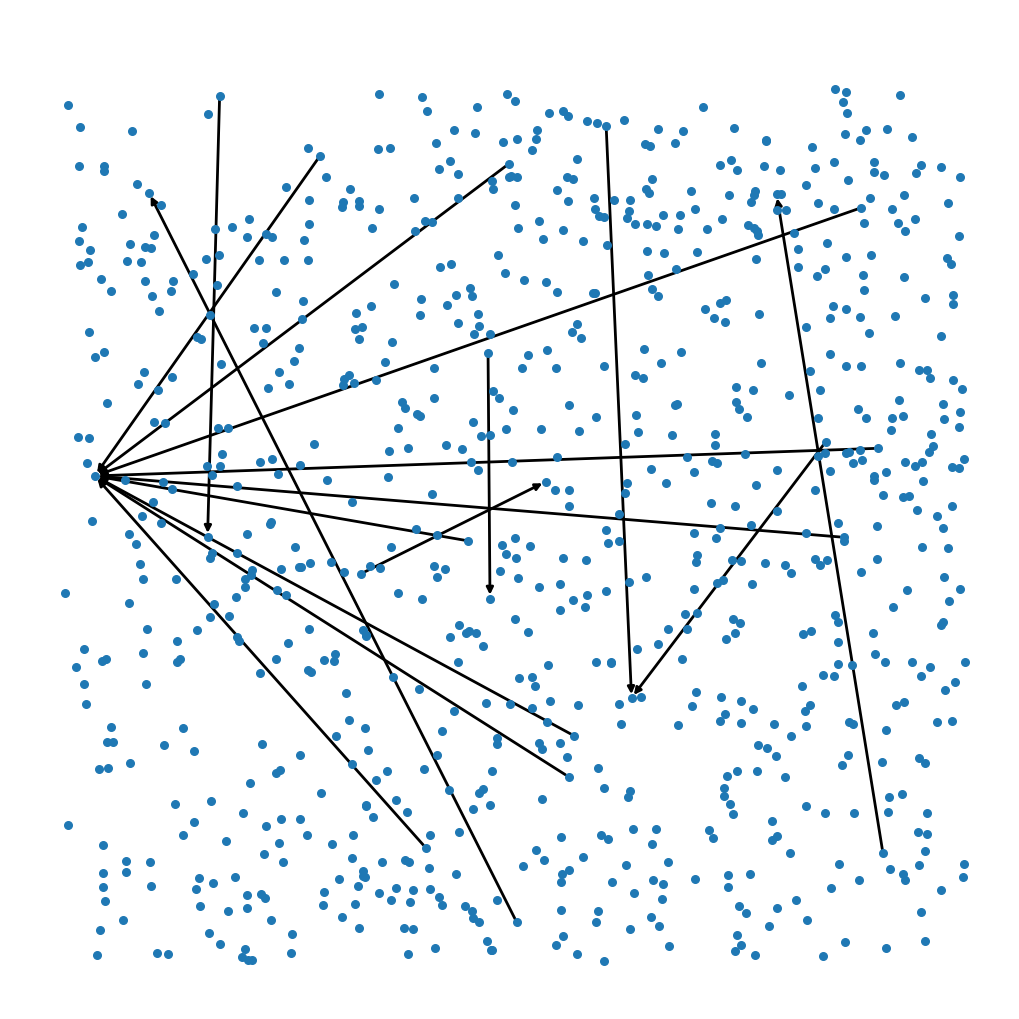

In [18]:
subset_nodes = select_subset_nodes(data.g, node_type='paper', subset_size=1000)
subgraph = create_subgraph(nx_g, subset_nodes)

plt.figure(figsize=(10, 10))
pos = nx.random_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_size=30, edge_color="black", width=2)
plt.show()